In [1]:
# 기본 작업 경로 설정

import os
notebook_path = os.path.abspath("../readme.md")
notebook_dir = os.path.dirname(notebook_path)
os.chdir(notebook_dir)

# 현재 작업 디렉토리 출력
print("Current working directory: ", os.getcwd())

Current working directory:  /mnt/e/py_data/project_3_git


### https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md

In [2]:
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

# 데이터셋 경로와 형식 설정
register_coco_instances("face_data_set", {}, "data/ssd_rcnn_face/annotations.json", "data/yolo_data/train/")

# 메타데이터를 확인합니다.
metadata = MetadataCatalog.get("face_data_set")
dataset_dicts = DatasetCatalog.get("face_data_set")

In [4]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.model_zoo import model_zoo

setup_logger()

cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("face_data_set",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 사용자 클래스 수로 설정
cfg.OUTPUT_DIR = "./models/faster_rcnn_R_50_FPN_3x"

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/05 23:30:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[09/05 23:30:22 d2.engine.train_loop]: Starting training from iteration 0
[09/05 23:30:25 d2.utils.events]:  iter: 1  total_loss: 1.739  loss_cls: 1.552  loss_box_reg: 0.1174  loss_rpn_cls: 0.06213  loss_rpn_loc: 0.006909    data_time: 0.1674  last_data_time: 0.0062   lr: 0.0005005  max_mem: 1808M
[09/05 23:30:25 d2.engine.hooks]: Total training time: 0:00:02 (0:00:02 on hooks)


[09/05 23:32:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from models/faster_rcnn_R_50_FPN_3x/model_final.pth ...


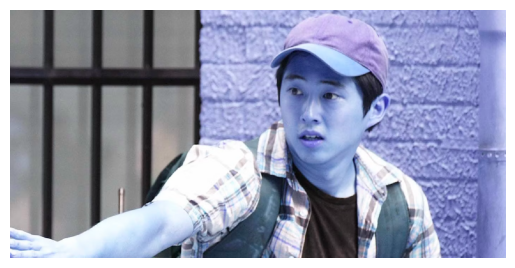

In [7]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt

# 모델 설정 및 가중치 로드
cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "models/faster_rcnn_R_50_FPN_3x/model_final.pth"  # 학습된 모델의 가중치 파일 경로
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # 예측 결과의 임계값 설정
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 사용자 클래스 수로 설정
cfg.DATASETS.TEST = ("face_data_set", )  # 예측할 데이터셋 설정

predictor = DefaultPredictor(cfg)

# 예측할 이미지 로드
image_path = "test.png"  # 예측할 이미지 경로
im = cv2.imread(image_path)

# 예측 수행
outputs = predictor(im)

# 예측 결과 시각화
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("face_data_set"), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# 결과 출력
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()
